In [1]:
data_dir = '../data'
image_dir = '../images'
model_dir = '../models'

In [2]:
fname = 'BankChurn_clean.csv'
target_var = 'Exited'

dtype = {
 'Gender': 'category',
 'Geography': 'category',
 'HasCrCard': 'category',
 'IsActiveMember': 'category'}

label_map = {0: 'Not Exited', 1: 'Exited'}

test_size_train_temp = .2
test_size_val_test = .5

cols_to_drop = []
random_state = 1

In [3]:
from datetime import datetime
import pandas as pd
today = datetime.today().strftime('%Y-%m-%d')

In [4]:
def get_saved_model(ind):
  model = None
  is_saved = False
  import os
  from tensorflow import keras
  if f'model{ind}.keras' in os.listdir(model_dir):
    is_saved = True
    model = keras.models.load_model(f"{model_dir}/model{ind}.keras")
  return model, is_saved

In [5]:
# import pandas as pd
# res = pd.read_csv(f'{model_dir}/results.csv')

In [6]:
df_clean = pd.read_csv(f'{data_dir}/{fname}', dtype=dtype)
# df_clean = df_clean.head(300)

In [7]:
df_clean

,Age,Balance (K),CreditScore,EstimatedSalary (K),Exited,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,42,0.00000,619,101.34888,1,Female,France,1,1,1,2
1,41,83.80786,608,112.54258,0,Female,Spain,0,1,1,1
2,42,159.66080,502,113.93157,1,Female,France,1,0,3,8
3,39,0.00000,699,93.82663,0,Female,France,0,0,2,1
4,43,125.51082,850,79.08410,0,Female,Spain,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
9995,39,0.00000,771,96.27064,0,Male,France,1,0,2,5
9996,35,57.36961,516,101.69977,0,Male,France,1,1,1,10
9997,36,0.00000,709,42.08558,1,Female,France,0,1,1,7
9998,42,75.07531,772,92.88852,1,Male,Germany,1,0,2,3


In [8]:
df_clean[target_var].dtype =='category'

False

In [9]:
nunique = df_clean[target_var].nunique()
is_classification = df_clean[target_var].dtype in [int, 'category'] and nunique < 20
multi_class = is_classification and nunique > 2
loss = 'binary_crossentropy' if is_classification else 'mean_squared_error'
if multi_class:
  loss = 'categorical_crossentropy'

chosen_metric = "recall" if is_classification else "r2_score"
num_classes = nunique if is_classification else None
out_activation = 'sigmoid' if is_classification else 'linear'
if multi_class:
  out_activation = 'softmax'

In [10]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import time

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

import tensorflow as tf #An end-to-end open source machine learning platform
from tensorflow import keras  # High-level neural networks API for deep learning.
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import Dense, Dropout


# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import random

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")
import inspect

/Users/oz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
def clean_reset_seed(random_state):
  tf.keras.backend.clear_session()
  if not is_classification:
    keras.utils.set_random_seed(random_state)

    # If using TensorFlow, this will make GPU ops as deterministic as possible,
    # but it will affect the overall performance, so be mindful of that.
    tf.config.experimental.enable_op_determinism()
  else:
    # Fixing the seed for random number generators
    np.random.seed(random_state)
    random.seed(random_state)
    tf.random.set_seed(random_state)

In [12]:
clean_reset_seed(random_state)

In [13]:
def add_dummies(df, cols=[]):
  df = pd.get_dummies(df, drop_first=True)
  df = df.astype('float')
  if cols:
    cols_not_in_df = [c for c in cols if c not in df.columns]
    for c in cols_not_in_df:
      df[c] = 0
    return df[cols]
  return df

def print_missing_values_columns(df, name=None):
    """
    Filters and prints only the columns from the DataFrame df that contain missing values.

    Parameters:
    - df: DataFrame
        The DataFrame to check for missing values.
    """
    cols = df.columns[df.isnull().any()]
    counts = df[cols].isnull().sum()
    counts.rename('Missing Value Count', inplace=True)
    counts.sort_values(ascending=False, inplace=True)
    if name:
      counts.index.name = name

    # if counts.shape[0] > 0:
    #   display(counts)
    return counts



def get_var_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def replace_missing_values_groupby(data, groupby_cols=[]):
  missing_cols = []
  for k, v in data.items():
    if 'x_' in k:
      counts = print_missing_values_columns(v, k)
      missing_cols.extend(counts.index.tolist())

  missing_cols = list(set(missing_cols))
  if len(missing_cols)== 0:
    print('There are no missing values')
    return data

  print('\nColumns with missing values:', ', '.join(missing_cols))

  if groupby_cols:
    # Step 1: Calculate the median of specified columns in x_train grouped by groupby_cols
    grouped_median = data['x_train'].groupby(groupby_cols)[missing_cols].median()

    # Step 2: Use the calculated median to fill missing values in specified columns for corresponding groups in train, validation and test data
    for name in ['x_train', 'x_validation', 'x_test']:
      for col in missing_cols:
        x = data[name]
        get_row_tuple = lambda row: tuple([row[c] for c in groupby_cols])
        x[col] = x.apply(lambda row: row[col] if not pd.isna(row[col]) else grouped_median[col].get(get_row_tuple(row), np.nan), axis=1)
        data.update({name: x})
  else:
    # print('Impute using the median.')
    # Step 1: Calculate the median of specified columns in x_train
    median = data['x_train'][missing_cols].median()

    new_missing_cols = []
    # Step 2: Use the calculated median to fill missing values in specified columns for corresponding groups in train, validation and test data
    for name in ['x_train', 'x_validation', 'x_test']:
      for col in missing_cols:
        x = data[name]
        x[col] = x[col].fillna(median[col])
        data.update({name: x})
      counts = print_missing_values_columns(x, name)
      new_missing_cols.extend(counts.index.tolist())
    new_missing_cols = list(set(new_missing_cols))
    if len(new_missing_cols) == 0:
      print('There are no missing values')
  return data


In [14]:
df_clean.head()

,Age,Balance (K),CreditScore,EstimatedSalary (K),Exited,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,42,0.00000,619,101.34888,1,Female,France,1,1,1,2
1,41,83.80786,608,112.54258,0,Female,Spain,0,1,1,1
2,42,159.66080,502,113.93157,1,Female,France,1,0,3,8
3,39,0.00000,699,93.82663,0,Female,France,0,0,2,1
4,43,125.51082,850,79.08410,0,Female,Spain,1,1,1,2


In [15]:
print('null', df_clean.isnull().sum().sum())
print('duplicates' , df_clean.duplicated().sum())
data_clean = df_clean.drop_duplicates()

null 0
duplicates 0


In [16]:
def get_outliers(df):
  # checking the % outliers
  data_numeric = df.select_dtypes(include=["float64", "int64"])

  Q1 = data_numeric.quantile(0.25)  # To find the 25th percentile
  Q3 = data_numeric.quantile(0.75)  # To find the 75th percentile

  IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
  lower = (Q1 - 1.5 * IQR)
  upper = (Q3 + 1.5 * IQR)

  # cols = [c for c in data_numeric.columns if not data[c].nunique() < 7]
  # data_numeric = data_numeric[cols]
  outliers = (data_numeric < lower) | (data_numeric > upper)
  outlier_count = outliers.sum(axis=1)
  outlier_rows = df[outlier_count > 0]
  out = (outliers.sum() / len(df) * 100).round(1)
  out.index.name='Column'
  out.name='Outlier %'
  out.sort_values(ascending=False, inplace=True)
  display(out[out>0])
  outlier_columns = out[out>0].index.tolist()

  df_new = df.copy()

  for col in outlier_columns:
    r0 = df_new.shape[0]
    df_new = df_new[(df_new[col] >= lower[col]) & (df_new[col] <= upper[col])]
    r1 = df_new.shape[0]
    print(col, round((r0-r1)/float(r0),2))

  # outlier detection using boxplot
  numeric_columns = df.select_dtypes(include=np.number).columns.tolist()


  plt.figure(figsize=(15, 6))

  for i, variable in enumerate(outlier_columns):
      plt.subplot(2, 5, i + 1)
      plt.boxplot(df_clean[variable], whis=1.5)
      plt.tight_layout()
      plt.title(variable)

  plt.savefig(f"{image_dir}/outlier_boxplot.png", bbox_inches='tight');
  plt.show()

Column
Age              3.6
NumOfProducts    0.6
CreditScore      0.2
Name: Outlier %, dtype: float64

Age 0.04
NumOfProducts 0.01
CreditScore 0.0


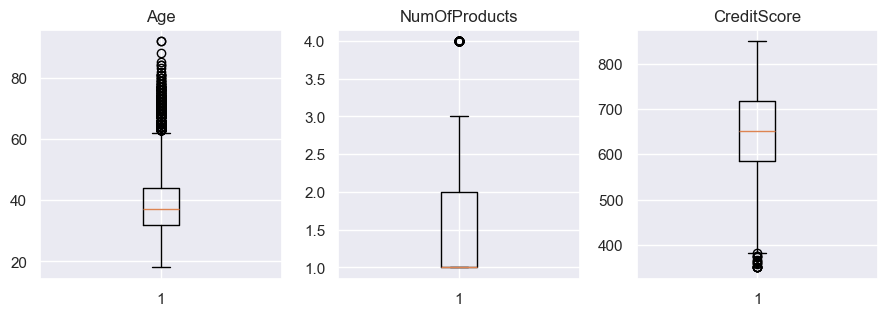

In [17]:
get_outliers(df_clean.drop(target_var, axis=1))

## Train Validation Test Split

In [18]:
# defining the dependent and independent variables
X = df_clean.drop([target_var], axis=1)
Y = df_clean[target_var]

In [19]:
to_dummy_cols = [c for c in X.select_dtypes(include=['category']).columns.tolist()
              if sorted(X[c].unique().tolist())!=['0', '1']]
num_columns = X.select_dtypes(include=['float', 'int']).columns.tolist()
print(f"Numerical columns: {', '.join(num_columns)}")
print(f"Columns to convert to dummy variables: {to_dummy_cols}")
X = pd.get_dummies(X, columns=to_dummy_cols, drop_first=True)
X = X.astype('float')

Numerical columns: Age, Balance (K), CreditScore, EstimatedSalary (K), NumOfProducts, Tenure
Columns to convert to dummy variables: ['Gender', 'Geography']


In [20]:
if cols_to_drop:
  print('Dropping columns: ', ', '.join(cols_to_drop))
  X = X.drop(cols_to_drop,axis=1)

In [21]:
print(f'Splitting the data in {int((1-test_size_train_temp)*100)}:{int(test_size_train_temp*100)} ratio for train and temporary data')
print(f'Splitting the temporary data in {int((1-test_size_val_test)*100)}:{int(test_size_val_test*100)} ratio for validation and test data')

Splitting the data in 80:20 ratio for train and temporary data
Splitting the temporary data in 50:50 ratio for validation and test data


In [22]:
x_train, x_temp, y_train, y_temp = train_test_split(X, Y,
                                                    test_size=test_size_train_temp,
                                                    random_state=random_state,
                                                    stratify=Y,
                                                    shuffle = True)

x_validation, x_test, y_validation, y_test = train_test_split(x_temp,y_temp,
                                             test_size=test_size_val_test,
                                             random_state=random_state,
                                             stratify=y_temp,
                                             shuffle = True)

In [23]:
data = {k: eval(k) for k in [f'x_{n}'
                             for n in ['train', 'validation', 'test']] +
                              [f'y_{n}' for n in ['train', 'validation', 'test']]}


def get_class_proportions(d):
  return (100*d.value_counts(normalize=True)).round(2).to_dict()


def print_data_shapes(data, name=''):
  over_or_under = False
  part_shapes = pd.DataFrame(columns=['Rows', 'Columns', 'Proportion %', 'Class Proportions %'])
  L = ['train', 'validation', 'test']
  if 'over' in name.lower() or 'under' in name.lower():
    over_or_under = True
    L = ['train', 'validation']
  for n in L:
    part_shapes.loc[f'X {n.title()}'] = [data[f'x_{n}'].shape[0], data[f'x_{n}'].shape[1], round(data[f'x_{n}'].shape[0]/X.shape[0]*100), get_class_proportions(data[f'y_{n}'])]
  part_shapes['Rows']=part_shapes['Rows'].apply(lambda x: f'{x:,}')
  if name:
    part_shapes.index.name = name

  if over_or_under:
    part_shapes.drop('Proportion %', axis=1, inplace=True)

  display(part_shapes)

In [24]:
def get_loss_metric(chosen_metric):
  names = os.listdir(image_dir)
  out = [f'{image_dir}/{f}' for f in names if f'loss_{chosen_metric}' in f]
  return out

def show_image(path):

  # Load the image from a file
  img = mpimg.imread(path)  # Replace with your image path
  plt.figure(figsize=(4, 8))
  # Display the image
  plt.imshow(img)
  plt.axis('off')  # Hides the axis for a cleaner display
  plt.show()

def show_specific_metric_loss(index, chosen_metric):
  path = f'{image_dir}/model_{index}_loss_{chosen_metric}.png'
  if path.split('/')[1] in os.listdir(image_dir):
    show_image(path)

In [25]:
print_data_shapes(data, name='Original')

,Rows,Columns,Proportion %,Class Proportions %
Original,,,,
X Train,"8,000",11,80,"{0: 79.62, 1: 20.38}"
X Validation,"1,000",11,10,"{0: 79.7, 1: 20.3}"
X Test,"1,000",11,10,"{0: 79.6, 1: 20.4}"


## Missing Value Treatment

In [26]:
need_missing_value_treatment = False
missing_cols = X.columns[X.isnull().any()].tolist()
non_missing_cols = [c for c in X.columns if c in missing_cols]
if len(missing_cols) > 0:
  need_missing_value_treatment = True
  print('Columns with missing values:', ', '.join(missing_cols))
else:
  print('There are no missing values.')

  for k, v in data.items():
    if 'x_' in k:
      counts = print_missing_values_columns(v, k)
      if counts.shape[0]>0:
        display(counts)

if need_missing_value_treatment:
  # data = replace_missing_values_groupby(data, groupby_cols=['Brand', 'Model'])
  # data = replace_missing_values_groupby(data, groupby_cols=['Brand'])
  data = replace_missing_values_groupby(data, groupby_cols=[])

There are no missing values.


## Convert y to categorical

In [27]:
if is_classification:
  if num_classes > 2:
    for name, _ in data.items():
      if 'y_' in name:
        _ = keras.utils.to_categorical(_, num_classes)
        print(name)
        print(_.shape)
        data.update({name: _})

## Normalizing the Numerical Values

In [28]:
# Define the columns to scale
print('Numerical columns: ', ', '.join(num_columns))

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns in the x_train data
scaler.fit(data['x_train'][num_columns])

# Transform selected columns in x_train, x_val, and x_test using the fitted scaler

for name, x in data.items():
  if 'x_' in name:
    x[num_columns] = scaler.transform(x[num_columns])
    data.update({name: x})

Numerical columns:  Age, Balance (K), CreditScore, EstimatedSalary (K), NumOfProducts, Tenure


# encoding the categorical variables

In [29]:
data['x_train'].head()

,Age,Balance (K),CreditScore,EstimatedSalary (K),HasCrCard,IsActiveMember,NumOfProducts,Tenure,Gender_Male,Geography_Germany,Geography_Spain
4256,3.516577,0.925750,-0.556600,-1.505216,1.0,1.0,-0.914333,1.380964,0.0,0.0,1.0
9151,0.956282,-1.219862,-0.370472,1.614655,1.0,0.0,0.797901,-1.376312,1.0,0.0,0.0
696,2.189016,-0.194773,-2.118010,-0.405078,1.0,1.0,-0.914333,-1.376312,1.0,0.0,1.0
4898,0.102850,-1.219862,-1.094304,1.067959,0.0,1.0,-0.914333,0.691645,0.0,0.0,0.0
6427,-0.181627,-1.219862,0.994469,0.756245,1.0,0.0,0.797901,-1.031652,1.0,0.0,0.0


In [30]:
print_data_shapes(data, name='Original (with dummy variables)')

,Rows,Columns,Proportion %,Class Proportions %
Original (with dummy variables),,,,
X Train,"8,000",11,80,"{0: 79.62, 1: 20.38}"
X Validation,"1,000",11,10,"{0: 79.7, 1: 20.3}"
X Test,"1,000",11,10,"{0: 79.6, 1: 20.4}"


In [31]:
data_over = data.copy()
data_under = data.copy()

In [32]:
# Synthetic Minority Over Sampling Technique
# sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=1)

for n in ['train', 'validation']:
  data_over[f'x_{n}'], data_over[f'y_{n}'] = sm.fit_resample(data[f'x_{n}'], data[f'y_{n}'])
  data_under[f'x_{n}'], data_under[f'y_{n}'] = rus.fit_resample(data[f'x_{n}'], data[f'y_{n}'])

# print('Original Data\n'+'-'*20)
# for k, v in data.items():
#   print(f'{k}: {v.shape}')

# print('\nOver-Sampled Data\n'+'-'*20)
# for k, v in data_over.items():
#   print(f'{k}: {v.shape}')

# print('\nUnder-Sampled Data\n'+'-'*20)
# for k, v in data_under.items():
#   print(f'{k}: {v.shape}')

print_data_shapes(data, name='Original')
print_data_shapes(data_under, name='Under-Sampled')
print_data_shapes(data_over, name='Over-Sampled')

,Rows,Columns,Proportion %,Class Proportions %
Original,,,,
X Train,"8,000",11,80,"{0: 79.62, 1: 20.38}"
X Validation,"1,000",11,10,"{0: 79.7, 1: 20.3}"
X Test,"1,000",11,10,"{0: 79.6, 1: 20.4}"


,Rows,Columns,Class Proportions %
Under-Sampled,,,
X Train,"3,260",11,"{0: 50.0, 1: 50.0}"
X Validation,406,11,"{0: 50.0, 1: 50.0}"


,Rows,Columns,Class Proportions %
Over-Sampled,,,
X Train,"12,740",11,"{0: 50.0, 1: 50.0}"
X Validation,"1,594",11,"{0: 50.0, 1: 50.0}"


In [33]:
x_train = data['x_train']
x_validation = data['x_validation']
x_test = data['x_test']

In [34]:
def plot(history, name, name1 = 'loss', model_name=''):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(4,8)) #Creating a subplot with figure and axes.
    # fig.suptitle(f'Model {model_name}')
    axes[0].plot(history.history[name1], label='Train') #Plotting the train accuracy or train loss
    axes[0].plot(history.history['val_'+name1], label='Validation') #Plotting the validation accuracy or validation loss
    title = name1.replace('_', ' ').title()
    axes[0].set_title(f'Model {model_name}')
    axes[0].set_ylabel(name1.title())
    axes[0].legend(frameon=False)
    axes[0].grid(True)
    sns.despine(ax=axes[0], top=True, right=True)

    axes[1].plot(history.history[name], label='Train') #Plotting the train accuracy or train loss
    axes[1].plot(history.history['val_'+name], label='Validation') #Plotting the validation accuracy or validation loss
    title = name.replace('_', ' ').title()
    # axes[1].set_title(title)
    axes[1].set_ylabel(name.title())
    axes[1].set_xlabel('Epoch')
    # axes[1].legend()
    axes[1].grid(True)
    sns.despine(ax=axes[0], top=True, right=True)
    axes[1].legend().remove()
    plt.tight_layout()

    plt.savefig(f"{image_dir}/model_{model_name}_{name1}_{name}.png", bbox_inches='tight');


    # plt.title(f'Model {model_name} - ' + title) #Defining the title of the plot.
    # plt.ylabel(title) #Capitalizing the first letter.
    # plt.xlabel('Epoch') #Defining the label for the x-axis.
    # #Defining the legend, loc controls the position of the legend.
    # fig.legend(['Train', 'Validation'], loc="outside right")
    # sns.despine(top=True, right=True)



# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


def model_performance(model,predictors,target):
  if is_classification:
    return model_performance_classification(model,predictors,target)
  else:
    return model_performance_regression(model,predictors,target)

def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = np.round(model.predict(predictors))
    if not isinstance(pred, pd.Series):
      if pred.shape[1] > 1:
        pred = pd.Series(np.argmax(pred, axis=1), index = predictors.index)
    if not isinstance(target, pd.Series):
      if target.shape[1] > 1:
        target = pd.Series(np.argmax(target, axis=1), index = predictors.index)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='macro')  # to compute Recall
    precision = precision_score(target, pred, average='macro')  # to compute Precision
    f1 = f1_score(target, pred, average='macro')  # to compute F1-score

    info = {
        "Accuracy": round(acc, 3),
        "Recall": round(recall, 3),
        "Precision": round(precision, 3),
        "F1": round(f1, 3),
    }
    return info, pred

# function to compute different metrics to check performance of a neural network model
def model_performance_regression(model,predictors,target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """
    # predicting using the independent variables
    pred = model.predict(predictors).reshape(-1)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    info =  {
            "RMSE": [rmse],
            "MAE": [mae],
            "R-squared": [r2],
            "Adj. R-squared": [adjr2],
            "MAPE": [mape]}


    return info, pred


def get_metrics(chosen_metric):
  if chosen_metric =='r2_score':
    return [tf.keras.metrics.R2Score(name=chosen_metric)]
  elif chosen_metric =='accuracy':
    return [tf.keras.metrics.Accuracy(name=chosen_metric)]




def make_train_model(data,
                     layers = [],
                     name = '',
                     loss=loss,
                     optimizer=keras.optimizers.SGD(),
                     batch_size=32,
                     epochs=10,
                     verbose=0,
                     metrics=get_metrics(chosen_metric),
                     sampling = 'Original',
                     ):

  learning_rate = '-'
  x_train = data['x_train']
  y_train = data['y_train']
  x_validation = data['x_validation']
  y_validation = data['y_validation']

  # clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
  clean_reset_seed(random_state)
  #Initializing the neural network
  model = Sequential()
  for layer in layers:
    model.add(layer)
  model.summary()

  if isinstance(optimizer, str):
    optimizer_name = optimizer
  else:
    optimizer_name = optimizer.__class__.__name__


  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics,
                run_eagerly=True)

  # print(batch_size, model.layers[0].input_shape)

  initializer = model.layers[0].kernel_initializer.__class__.__name__

  start = time.time()
  history = model.fit(x_train, y_train,
                      validation_data=(x_validation,y_validation),
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose
                      )
  end=time.time()
  elapsed_time = end - start
  print(f"Time taken in seconds {elapsed_time:.2f}")

  if optimizer_name == 'SGD':
    if batch_size > 1000:
      optimizer_name = 'GD'


  optimizer_params = model.optimizer.get_config()
  learning_rate = optimizer_params.get('learning_rate', '-')
  momentum = str(optimizer_params.get('momentum', '-'))
  # if not 'momentum' in optimizer_params.keys():
  #   momentum = optimizer_params.get('ema_momentum', '-')
  optimizer_name = optimizer_params.get('name', optimizer_name)

  info = {k: '-' for k in columns}
  hidden_layers = []
  dense_layers = [layer for layer in layers if isinstance(layer, Dense)]
  dropout_layers = [l for l in model.layers if isinstance(l, Dropout)]
  dropout_configs = [l.get_config() for l in dropout_layers]
  regularization = [f"Dropout({c['rate']})" for c in dropout_configs]
  if len(layers)>1:
    hidden_layers = dense_layers[:-1]
  info.update({
      "# Hidden Layers": len(hidden_layers)
      ,"# Dropout Layers": len(dropout_layers)
      ,"# Neurons": list(map(lambda l: l.units, dense_layers))
      ,"Activation Function": list(map(lambda l: l.activation.__name__, dense_layers))
      ,"# Neurons (Hidden)": list(map(lambda l: l.units, hidden_layers))
      ,"Activation Function (Hidden)": list(map(lambda l: l.activation.__name__, hidden_layers))
      ,'# Epochs': epochs
      ,'Batch Size': batch_size
      ,'Optimizer': optimizer_name
      ,'Learning Rate': learning_rate
      ,'Momentum': momentum
      ,'Weight Initializer': initializer
      ,'Regularization': regularization
      ,'Sampling': sampling
      ,'Time (min)': round(elapsed_time/60, 2)
      ,'Train Loss': history.history["loss"][-1]
      ,'Validation Loss': history.history["val_loss"][-1]
      ,f'Train {chosen_metric.title()}': history.history[chosen_metric][-1]
      ,f'Validation {chosen_metric.title()}': history.history[f"val_{chosen_metric}"][-1]
  })
  info.update({f'|Train - Validation| {chosen_metric.title()}': abs(info[f'Train {chosen_metric.title()}']-info[f'Validation {chosen_metric.title()}'])})

  plot(history, chosen_metric, model_name=name)
  clean_reset_seed(random_state)
  return info, model


def confusion_matrix_sklearn(model, predictors, target, figsize=(6, 4),
                             rotation_x = 0, rotation_y=0, cmap='Blues', name='',
                             partition='', label_map = {}):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    pred = np.round(model.predict(predictors))

    if not isinstance(pred, pd.Series):
      if pred.shape[1] > 1:
        pred = pd.Series(np.argmax(pred, axis=1), index = predictors.index)
    if not isinstance(target, pd.Series):
      if target.shape[1] > 1:
        target = pd.Series(np.argmax(target, axis=1), index = predictors.index)

    pred = pd.Series(pred.reshape(-1), index = predictors.index)

    cm = confusion_matrix(target, pred)
    cm_df = pd.DataFrame(cm)

    num_classes = target.nunique()

    labels = np.asarray(
        [
            [f"{item:,}"+ f"\n\n{item / cm.flatten().sum():.0%}"]
            for item in cm.flatten()
        ]
    ).reshape(num_classes, num_classes)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm_df, annot=labels, fmt="", square = True, cmap=cmap,
                     linewidth=2)

    if label_map:
      labs = label_map.values()
      ax.set_xticklabels(labs, rotation=rotation_x, ha='right')
      ax.set_yticklabels(labs, rotation=rotation_y)
    else:
      ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_x, ha='right')
      ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation_y)


    name = f'Confusion Matrix\n{name}\n{partition} Data'
    plt.title(name)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tick_params(left=False, bottom=False)
    name_modified = name.replace('\n', '_').replace(' ', '_')
    if label_map:
      name_modified += '_map'

    plt.savefig(f"{image_dir}/{name_modified}.png", bbox_inches='tight');
    plt.show();


In [35]:
columns = [
          "# Neurons"
          ,"Activation Function"
          ,"# Hidden Layers"
          ,"# Dropout Layers"
          ,"# Neurons (Hidden)"
          ,"Activation Function (Hidden)"
          ,"# Epochs"
          ,"Batch Size"
          ,"Optimizer"
          ,"Learning Rate"
          ,"Momentum"
          ,"Weight Initializer"
          ,"Regularization"
          ,"Time (min)"
          ,"Train Loss"
          ,"Validation Loss"
          ,"Sampling"
          ,f'Train {chosen_metric.title()}'
          ,f'Validation {chosen_metric.title()}'
          ,f'|Train - Validation| {chosen_metric.title()}']

results = pd.DataFrame(columns=columns)
#Defining the list of metrics to be used for all the models.
metrics = [eval(f"tf.keras.metrics.{chosen_metric.title()}(name='{chosen_metric}')")]
ind = 0
models = {}

In [36]:
def get_out_neuron(num_classes):
  if is_classification:
    if num_classes > 2:
      return num_classes
  return 1

out_neuron = get_out_neuron(num_classes)

In [37]:
out_neuron

1

In [38]:
#results['Momentum'] = '-'

In [39]:
def get_momentum(optimizer):
  optimizer_params = optimizer.get_config()
  momentum = str(optimizer_params.get('momentum', '-'))
  return momentum

In [40]:
def make_model_save_results(results, models, ind, data,
                     layers = [],
                     name = '',
                     loss=loss,
                     optimizer=keras.optimizers.SGD(),
                     batch_size=32,
                     epochs=10,
                     verbose=0,
                     metrics=get_metrics(chosen_metric),
                     sampling = 'Original'):

  model, is_saved = get_saved_model(ind)

  if not is_saved:

    info, model = make_train_model(data,
                        layers = layers,
                        batch_size = batch_size,
                        name = ind,
                        sampling = sampling,
                        metrics = metrics,
                        optimizer=optimizer,
                        epochs=epochs)
    results.loc[ind] = info
    model.save(f'{model_dir}/model{ind}.keras')
    display(results)
    results.to_csv(f'{model_dir}/results.csv', index=False)
  models[ind] = model
  return results, models

In [41]:
models = {}
ind = 0

In [42]:
results

,# Neurons,Activation Function,# Hidden Layers,# Dropout Layers,# Neurons (Hidden),Activation Function (Hidden),# Epochs,Batch Size,Optimizer,Learning Rate,Momentum,Weight Initializer,Regularization,Time (min),Train Loss,Validation Loss,Sampling,Train Recall,Validation Recall,|Train - Validation| Recall


In [ ]:
clean_reset_seed(random_state)
epochs = 120
batch_size = 32
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dense(32, activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind, data,
                      layers = layers,
                      batch_size = batch_size,
                      name = ind,
                      metrics = metrics,
                      optimizer=optimizer,
                      epochs=epochs)
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clean_reset_seed(random_state)
epochs = 120
batch_size = 32
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dense(32, activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind, data,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     epochs=epochs)
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(16,activation='relu'),
          Dense(8,activation='relu'),
          Dropout(.1),
          Dense(4,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     epochs=epochs)
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dense(16,activation='relu'),
          Dense(8,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.SGD()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dense(16,activation='relu'),
          Dense(8,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_under,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Under',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Under'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dense(16,activation='relu'),
          Dense(8,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(16,activation='relu'),
          Dropout(.1),
          Dense(8,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(16,activation='relu'),
          Dropout(.1),
          Dense(8,activation='relu'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(32, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
ind =9

In [ ]:
clean_reset_seed(random_state)
epochs = 150
batch_size = 32
layers = [Dense(32, activation='tanh',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(32, activation='tanh'),
          Dropout(.1),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.Adam()
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(32, activation='tanh'),
          Dropout(.1),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=.95)
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
momentum = .9
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.2),
          Dense(32, activation='tanh'),
          Dropout(.1),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=momentum)
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
clean_reset_seed(random_state)
epochs = 100
batch_size = 32
momentum = .95
layers = [Dense(64, activation='relu',input_dim=x_train.shape[1]),
          Dropout(.3),
          Dense(32, activation='tanh'),
          Dropout(.2),
          Dense(16,activation='tanh'),
          Dropout(.1),
          Dense(8,activation='tanh'),
          Dense(out_neuron, activation=out_activation)]

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=momentum)
metrics = [chosen_metric]

results, models = make_model_save_results(results, models, ind,data_over,
                     layers = layers,
                     batch_size = batch_size,
                     name = ind,
                     metrics = metrics,
                     optimizer=optimizer,
                     sampling = 'Over',
                     epochs=epochs)
results.loc[ind, 'Sampling'] = 'Over'
# results.loc[ind, 'Momentum'] = get_momentum(optimizer)
ind +=1

In [ ]:
results

In [ ]:
results.to_csv(f'{model_dir}/results.csv', index=False)

In [ ]:
results_sorted = (results
 .sort_values(by=[f'Validation {chosen_metric.title()}',
                  f'Train {chosen_metric.title()}', f'|Train - Validation| {chosen_metric.title()}'],
              ascending=[False, False, True]))

display(results_sorted)
index = results_sorted.head(1).index.values[0]
selected_result = results.loc[index]
selected_dict = selected_result.to_dict()
display(selected_result)
selected_sampling = selected_dict['Sampling']
print(f'Chose index: {index}')

In [ ]:
from tensorflow import keras

selected_model_loaded = keras.models.load_model(f"{model_dir}/model{index}.keras")

In [ ]:
selected_model = models[index]

In [ ]:
show_specific_metric_loss(index, chosen_metric)

In [ ]:
data_under.keys()

In [ ]:
perf_df = pd.DataFrame()
for n in ['train', 'validation', 'test']:
  if selected_sampling == 'Original':
    x = data[f'x_{n}']
    y = data[f'y_{n}']
  elif selected_sampling == 'Over':
    x = data_over[f'x_{n}']
    y = data_over[f'y_{n}']
  elif selected_sampling == 'Under':
    x = data_under[f'x_{n}']
    y = data_under[f'y_{n}']
  print(f'\n{n.upper()} Performance')
  perf, pred = model_performance(selected_model,x,y)
  perf_df = pd.concat([perf_df, pd.DataFrame(perf, index=[n.title()])])

  name = f"Model {index}"
  name += f"\n{selected_dict['Sampling']} Sampling"
  name +=f"\n{selected_dict['Optimizer'].title()} Optimizer"
  if selected_dict['# Hidden Layers']>0:
    name +=f"\n{selected_dict['# Hidden Layers']} Hidden Layers"
  if selected_dict['# Dropout Layers']>0:
    name +=f"\n{selected_dict['# Dropout Layers']} Dropout Layers"


  if n in ['test']:
    if is_classification:
      confusion_matrix_sklearn(selected_model, x, y, partition=n.title(), name=name, label_map =label_map)
      confusion_matrix_sklearn(selected_model, x, y, partition=n.title(), name=name, label_map ={})

display(perf_df)


In [ ]:
#ls images/model*loss_recall.png

In [ ]:
image_fnames = get_loss_metric(chosen_metric)
for f in image_fnames:
  show_image(f)

In [ ]:
resnew = results.copy()

resnew = resnew.drop(['# Hidden Layers', '# Neurons (Hidden)', 'Activation Function (Hidden)'], axis=1)
def conv_str_list_str(x):
  if type(x) == str:
    x = eval(x)
  if x == []:
    return ''
  return ', '.join([str(i) for i in x])


for col in ['Activation Function', 'Regularization', '# Neurons']:
  resnew[col] = resnew[col].apply(lambda x: conv_str_list_str(x))
resnew = resnew.rename(columns={'Validation Recall': 'Valid Recall', '|Train - Validation| Recall': '|Train - Valid| Recall', 'Regularization': 'Reg.', 'Weight Initializer': 'Weight Init.'})
resnew.head()

In [ ]:
resnew.columns.tolist()

In [ ]:
col_orders = ['Sampling',
 '# Neurons',
 'Activation Function',
 '# Dropout Layers',
 '# Epochs',
 'Batch Size',
 'Optimizer',
 'Learning Rate',
 'Momentum',
 'Weight Init.',
 'Reg.',
 'Train Loss',
 'Validation Loss',
 'Train Recall',
 'Valid Recall',
 '|Train - Valid| Recall',
  'Time (min)']

In [ ]:
resnew[col_orders]

In [ ]:
#results = pd.read_csv(f'{model_dir}/results.csv')
#results = pd.read_csv(f'{model_dir}/results.csv').drop('Unnamed: 0', axis=1)
#results.to_csv(f'{model_dir}/results.csv', index=False)